# An Introduction to Co-Word Analysis

Co-word analysis is the investigation of the semantic structure of a corpus of textual data through the co-occurrence of terms. By analysing the co-occurrence of terms, a network of connected terms is generated, which enables the application of algorithms developed in graph theory to uncover underlying structures (normally referred to as themes) and examine the nature of the connections behind the terms. For example, centrality measures are often used to identify the most important and influential terms within the network structure. In addition, clustering algorithms such as Louvain community partitioning are used to identify groups of highly connected terms within a network. A primary application of co-word analysis has been the identification of research themes and key terms within scientific communities ([Ding et al. 2001][1]; [Coulter et al.][2]; [Liu et al. 2014][3]).

This notebook provides a brief introduction and demmonstration of some of the techniques that are used in co-word analysis. Hopefully it will give you a good starting point as well as the confidence to try it out on your datasets. In this introduction, we will be applying co-word analysis on the keywords used by conference papers in DESIGN 2012.

The analysis is broken down in 5 steps and covers:

* Importing the relevant python packages and data;
* Generating a co-word network of keywords;
* Visualising the co-word network;
* Clustering the co-word network; and,
* Identifying key terms within the network.


[1]: http://www.sciencedirect.com/science/article/pii/S0306457300000510
[2]: http://onlinelibrary.wiley.com/doi/10.1002/(SICI)1097-4571(1998)49:13%3C1206::AID-ASI7%3E3.0.CO;2-F/epdf
[3]: http://delivery.acm.org/10.1145/2560000/2556969/p3553-liu.pdf?ip=137.222.114.243&id=2556969&acc=ACTIVE%20SERVICE&key=BF07A2EE685417C5%2E3DCFD3605FE4B4CE%2E4D4702B0C3E38B35%2E4D4702B0C3E38B35&CFID=638504200&CFTOKEN=96987752&__acm__=1467362675_d2665f24777acc735ff8e1e8f1bc2ab6

In [27]:
# A line of code that jupyter notebook uses to plot the images inline with the code and text
%matplotlib inline
# do not automatically use tight_layout
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

import networkx as nx # Network creation, drawing and analysing package
import json # for reading json data
import matplotlib.pyplot as plt # for plotting networks diagrams
import community # Louvain community clusering algorithm
import collections # Counting occurrences of items within lists
import operator # for sorting dictionary objects

# Custom settings for the python notebook to save images as svg rather than png
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

## Importing the data into python

In [28]:
# load the data from the file
with open('DESIGN2012.json', 'r', encoding='iso-8859-15') as f:
    data = f.read()

# read json object
data = json.loads(data)
papers = data['rows']
# pretty print an example data row
print(papers[0])

{'publication_author': 'Achiche S., Howard T. J., McAloone T. C., Deng L., Baron L.', 'publication_conf_code': 'DESIGN 2012', 'publication_title': 'THE UNDERLYING RELATIONSHIPS BETWEEN SUCCESS CRITERIA &amp; SUCCESS FACTORS IN NPD ACTIVITIES', 'publication_keyword': 'new product development, success criteria and factors, project management'}


## Extracting the keywords and counting their occurrences

Number of Keywords: 843
[('design process', 10), ('design methods', 7), ('product development', 7), ('knowledge management', 7), ('product development process', 6), ('product-service systems', 5), ('cad', 5), ('design structure matrix', 5), ('uncertainty', 5), ('innovation', 5)]


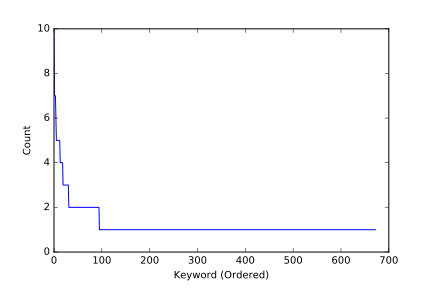

In [29]:

keyword_list = [] # empty list
for paper in papers:
    keywords = paper['publication_keyword'].lower().split(',') # splitting keywords
    keywords = [x.strip() for x in keywords] # stripping whitespace
    keyword_list.extend(keywords) # add keywords to list
    
print('Number of Keywords:', len(keyword_list))
keyword_list = collections.Counter(keyword_list).most_common() # count the number of re-occurrences of keywords
print(keyword_list[0:10])

# create list of appearence for plotting
y = [k[1] for k in keyword_list]

# plotting the number of occurrences each keyword has had
plt.plot(y)
plt.ylim(0, 10)
plt.xlabel('Keyword (Ordered)')
plt.ylabel('Count')
plt.show()

## Creating the Nodes

In [30]:

# Generate Graph
g = nx.Graph()

# Get the keywords of interest
n = 0
graph_keywords = []
for i, keyword in enumerate(keyword_list):
    graph_keywords.append(keyword[0])
    g.add_node(n,
               keyword=keyword[0],
               freq=keyword[1]
              )
    n = n + 1

print('Number of Nodes in Network:', g.number_of_nodes())
        

Number of Nodes in Network: 673


## Creating the Edges (Co-occurrence of words)

In [31]:
# for each paper in the conference
for paper in papers:
    #g et the list of keywords from the paper
    keywords = paper['publication_keyword'].lower().split(',')
    keywords = [x.strip() for x in keywords]
    
    # loop through the keywords
    for i in range(0, len(keywords)-1):
        for j in range(i+1, len(keywords)):
        
            keyword_one_idx = graph_keywords.index(keywords[i])
            keyword_two_idx = graph_keywords.index(keywords[j])
                
            if g.has_edge(keyword_one_idx, keyword_two_idx):
                g[keyword_one_idx][keyword_two_idx]['weight'] = g[keyword_one_idx][keyword_two_idx]['weight'] + 1
            else:
                g.add_edge(keyword_one_idx, keyword_two_idx, weight=1)

print('Number of Edges in Network:', g.number_of_edges())

Number of Edges in Network: 1399


## Network Pruning


In [32]:
print('- Before Pruning -')
print('Number of Nodes in Network:', g.number_of_nodes())
print('Number of Edges in Network:', g.number_of_edges())

for n, d in g.nodes(data=True):
    if d['freq'] == 1:
        g.remove_node(n)
        
print('- After Pruning -')
print('Number of Nodes in Network:', g.number_of_nodes())
print('Number of Edges in Network:', g.number_of_edges())

- Before Pruning -
Number of Nodes in Network: 673
Number of Edges in Network: 1399
- After Pruning -
Number of Nodes in Network: 95
Number of Edges in Network: 134


## Graph Drawing

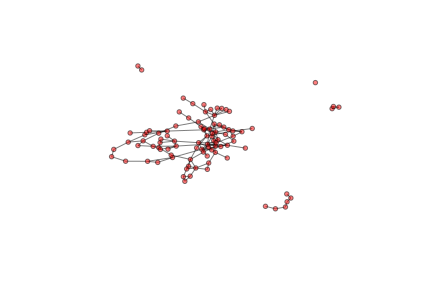

In [33]:
pos = nx.spring_layout(g)
nx.draw_networkx(g, 
                 node_size=20,
                 alpha=0.5,
                 with_labels=False,
                 pos=pos)

plt.axis('off')
plt.show()

## Applying Louvain Community Detection


Number of Partitions: 11


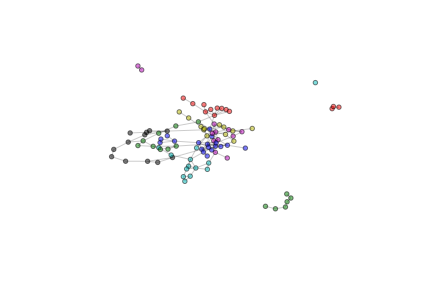

In [34]:
partition = community.best_partition(g)

colors = "bgrcmykbgrcmykbgrcmykbgrcmyk"

number_of_partitions = 0
for idx in partition: # iterate throught the dictionary
    if partition[idx] > number_of_partitions:
        number_of_partitions = partition[idx]
        
    nx.draw_networkx_nodes(g, 
                           nodelist=[idx], 
                           node_color=colors[partition[idx]],
                           node_size=20,
                           alpha=0.5,
                           pos=pos
                          )

nx.draw_networkx_edges(g,
                       alpha=0.2,
                       pos=pos
                      )

print('Number of Partitions:', number_of_partitions)

plt.axis('off')
plt.show()

## List nodes in a Cluster

In [35]:
cluster_number = 10

keywords = []
print('Cluster:', cluster_number)
for idx in partition:
    if partition[idx] == cluster_number:
        print(g.node[idx]['keyword'])



Cluster: 10
system architecture


## Using Betweeness Centrality to Idenitfy Key Terms


[Betweenness Centrality](https://networkx.github.io/documentation/development/reference/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality)

$$ c_B(v) = \sum_{s,t\in V}\frac{\sigma(s,t|v)}{\sigma(s,t)} $$


In [36]:
centralities = nx.betweenness_centrality(g)

sorted_centralities = sorted(centralities.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_centralities[0:5])

print(g.node[sorted_centralities[0][0]])
print(g.node[sorted_centralities[1][0]])
print(g.node[sorted_centralities[2][0]])


[(0, 0.31219482302186474), (1, 0.13542576795836914), (2, 0.13128002745367198), (3, 0.12858994890566613), (45, 0.11844734233203696)]
{'keyword': 'design process', 'freq': 10}
{'keyword': 'design methods', 'freq': 7}
{'keyword': 'product development', 'freq': 7}


## References & Additional Reading

### Extras

Additional pieces of code that handle the css styling for the notebook.

In [37]:
from IPython.core.display import HTML

styles = open("../extras/custom.css", "r").read()

HTML("<style>"+styles+"</style>")